In [1]:
from madhatter import *
from nltk.corpus import gutenberg
from nltk.corpus import europarl_raw

import pandas as pd
import spacy
import nltk

In [2]:
files = [gutenberg.raw(fileid)[:100_000] for fileid in gutenberg.fileids()]
# files = files*100

nlp = spacy.load("en_core_web_sm", disable=[
                 "ner",
                 #  "lemmatizer",
                 "textcat", "attribute_ruler"])
nlp.pipe_names


['tok2vec', 'tagger', 'parser', 'lemmatizer']

In [6]:
# %%memit
docs = nlp.pipe(files, n_process=-1)
for doc in docs:
    sent = list(doc.sents)[0]
    for token in sent:
        # print(token.text, token.tag_, token.pos_, token.dep_, token.is_stop)
        pass


/Users/Matey/miniconda3/envs/mlkit/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [26]:
% % mprun - f x
# for file in files:
#     bench = CreativityBenchmark(file)
#     sent = bench.tagged_sents[0]
#     for tup in sent:
#         # print(word)
#         pass


def x():
    def do_work(file):
        bench = CreativityBenchmark(file)
        sent = bench.tagged_sents[0]
        for tup in sent:
            # print(word)
            pass
        print(f"work_done-{file[:20]}")

    # from multiprocessing import pool
    from multiprocess import pool

    p = pool.Pool(processes=8)
    res = p.map(do_work, files)
# with pool.Pool() as p:
#     res = p.map(do_work, files)


x()


ERROR: Could not find file <string>
work_done-[Poems by William Bl
work_done-[Sense and Sensibili
work_done-[Persuasion by Jane 
work_done-[The Adventures of B
work_done-[Emma by Jane Austen
work_done-[The King James Bibl
work_done-[Stories to Tell to 
work_done-[Alice's Adventures 
work_done-[The Ball and The Cr
work_done-[The Wisdom of Fathe
work_done-[The Parent's Assist
work_done-[The Man Who Was Thu
work_done-[Moby Dick by Herman
work_done-[Paradise Lost by Jo
work_done-[The Tragedie of Jul
work_done-[The Tragedie of Ham
work_done-[The Tragedie of Mac
work_done-[Leaves of Grass by 



### Memory usage of Spacy vs Custom Package
| Framework | peak memory | increment |
|-----------|-------------|-----------|
| Spacy | 5089.13 MiB |  4465.29 MiB |
| Mad Hatter| 434.81 MiB  | 48.75 MiB |

Increment here is the more important number as it tells us how memory usage peaks when performing a given operation.


## Experimentation with pipelines
Here we prepare a pipeline that will take the list of resources and return a list of `Report` objects. Those `Report` objects are then fed into a Pandas dataframe for further analysis. For better performance, we use the `multiprocessing` module to parallelize the pipeline, as each text is largely independent.


Example listing of the pipeline:
```python
def pipeline(resources: list[str]):
    reports = []
    for resource in resources:
        report = Report(resource)
        reports.append(report)
    return reports
```

In [11]:
input_length = 100_000
creative_fn = [file for file in gutenberg.fileids()]
# creative_files = [gutenberg.raw(file)[:input_length] for file in creative_fn]
creative_files = [(gutenberg.raw(file)[:input_length], file) for file in creative_fn]

In [21]:
def process(file: str, title: Optional[str] = None) -> Report:
    if title is not None:
        bench = CreativityBenchmark(file, title)
    else:
        bench = CreativityBenchmark(file)
    return bench.report(print_time=False)


from multiprocess.pool import Pool

with Pool(16) as p:
    results = p.starmap(process, creative_files)
    
creative_df = pd.DataFrame(results)
creative_df.insert(creative_df.shape[1],"class", 1)
creative_df.head()

,title,nwords,mean_wl,mean_sl,mean_tokenspersent,prop_contentwords,mean_conc,prop_pos,class
0,austen-emma.txt,20736,3.944541,110.286674,24.076148,0.602334,2.667831,{},1
1,austen-persuasion.txt,20270,4.044401,165.212020,34.701169,0.582486,2.743174,{},1
2,austen-sense.txt,19658,4.186642,135.486968,27.850480,0.578085,2.706523,{},1
3,bible-kjv.txt,21870,3.660311,143.037681,32.607246,0.641381,2.980902,{},1
4,blake-poems.txt,8017,3.661345,104.236620,23.208451,0.754522,3.064218,{},1
5,bryant-stories.txt,21715,3.573843,84.632314,19.652402,0.650886,3.224254,{},1
6,burgess-busterbrown.txt,17695,3.787567,82.741259,18.523477,0.627409,3.129529,{},1
7,carroll-alice.txt,22445,3.573580,90.890943,21.387246,0.639162,2.986832,{},1
8,chesterton-ball.txt,20319,4.025346,94.539055,20.486017,0.629608,2.921392,{},1
9,chesterton-brown.txt,20080,4.038596,98.833843,21.326198,0.644223,3.056635,{},1


In [19]:
legal_texts = [" ".join([" ".join(para) for para in chap])[:100_000] for chap in europarl_raw.english.chapters()]

# legal_texts = []
# for chap in europarl_raw.english.chapters():    
#     legal_texts.append(" ".join([" ".join(para) for para in chap])[:100_000])


In [22]:
with Pool(16) as p:
    results = p.starmap(process, [(legal_text, f"legal_text_{i}") for i, legal_text in enumerate(legal_texts)])
    
legal_df = pd.DataFrame(results)
legal_df.insert(legal_df.shape[1], "class", 2)
legal_df.head()

,title,nwords,mean_wl,mean_sl,mean_tokenspersent,prop_contentwords,mean_conc,prop_pos,class
0,legal_text_0,1580,4.275949,125.303030,23.954545,0.579114,2.755893,{},2
1,legal_text_1,2803,4.173029,130.772727,25.481818,0.556190,2.761124,{},2
2,legal_text_2,2793,4.450412,170.011236,31.382022,0.583602,2.733620,{},2
3,legal_text_3,2463,4.397077,157.226190,29.321429,0.576533,2.670069,{},2
4,legal_text_4,11200,4.589196,176.801136,31.818182,0.577946,2.674267,{},2


After running the pipeline, we concatenate the results into a single dataframe which we can then use for further analysis. 

In [30]:
df = pd.concat([creative_df, legal_df], ignore_index=True)
df

,title,nwords,mean_wl,mean_sl,mean_tokenspersent,prop_contentwords,mean_conc,prop_pos,class
0,austen-emma.txt,20736,3.944541,110.286674,24.076148,0.602334,2.667831,{},1
1,austen-persuasion.txt,20270,4.044401,165.212020,34.701169,0.582486,2.743174,{},1
2,austen-sense.txt,19658,4.186642,135.486968,27.850480,0.578085,2.706523,{},1
3,bible-kjv.txt,21870,3.660311,143.037681,32.607246,0.641381,2.980902,{},1
4,blake-poems.txt,8017,3.661345,104.236620,23.208451,0.754522,3.064218,{},1
...,...,...,...,...,...,...,...,...,...
94,legal_text_76,5009,4.605909,145.223958,26.088542,0.586744,2.667809,{},2
95,legal_text_77,12822,4.346904,136.646586,25.753012,0.582826,2.733582,{},2
96,legal_text_78,2884,4.491678,142.963636,26.227273,0.576976,2.794737,{},2
97,legal_text_79,667,4.484258,303.750000,55.583333,0.556222,2.720667,{},2


## Experiment


In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

xdf = df.drop(["title", "class", "prop_pos"],axis=1)
ydf = df["class"]
xtrain, xtest, ytrain, ytest = train_test_split(xdf, ydf,test_size=0.1)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.1)

reg = LogisticRegression()
reg.fit(xtrain, ytrain)
predicts = reg.predict(xtest)

accuracy_score(predicts, ytest)

0.9

,0
nwords,-0.000486
mean_wl,0.147359
mean_sl,0.327840
mean_tokenspersent,-1.365483
prop_contentwords,-0.037810
mean_conc,-0.130022


<BarContainer object of 6 artists>

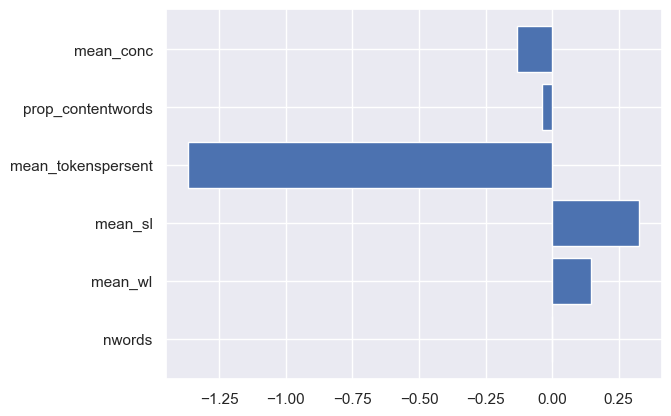

In [53]:
# reg.coef_

# xdf.columns

display_df = pd.DataFrame(reg.coef_.T, index=xdf.columns)
display(display_df)

import matplotlib.pyplot as plt

plt.barh(display_df.index,display_df[0])